In [1]:
import torch
from torch import nn

In [2]:
from scripts import muat_datasets
from pathlib import Path

data_path = Path('datasets')
train_dir, test_dir = muat_datasets.muat_data(data_path)

Path dataset sudah benar!


In [3]:
train_dir, test_dir

(WindowsPath('datasets/train'), WindowsPath('datasets/test'))

Direktori gambar: datasets\train\red_rot\redrot (143).jpeg
Class gambar: red_rot
Tinggi gambar: 918
Lebar gambar: 750


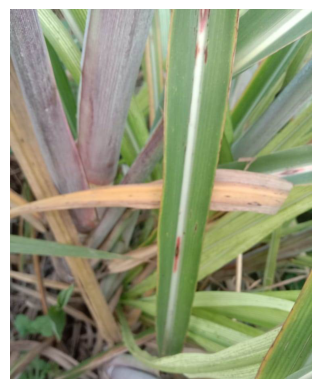

In [4]:
from scripts import visualization

visualization.cek_gambar(data_path)

In [5]:
import torchvision

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
weights = torchvision.models.ResNet50_Weights.DEFAULT
weights

ResNet50_Weights.IMAGENET1K_V2

In [8]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [9]:
from torchvision.transforms import v2

In [10]:
train_transform = v2.Compose([
    # v2.Resize(size = [224, 224]),
    # v2.Grayscale(num_output_channels = 1),
    v2.AugMix(),
    v2.TrivialAugmentWide(num_magnitude_bins = 31),
    auto_transforms
    # v2.ToImage(),
    # v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.Resize(size = [224, 224]),
    # v2.Grayscale(num_output_channels = 1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [11]:
train_transform

Compose(
      AugMix(interpolation=InterpolationMode.BILINEAR, severity=3, mixture_width=3, chain_depth=-1, alpha=1.0, all_ops=True)
      TrivialAugmentWide(interpolation=InterpolationMode.NEAREST, num_magnitude_bins=31)
      ImageClassification(
      crop_size=[224]
      resize_size=[232]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
)

In [12]:
train_data_loader, test_data_loader, class_names = muat_datasets.dataLoader(train_dir = train_dir,
                                                                            test_dir = test_dir,
                                                                            batch_size = 32, num_workers = 4,
                                                                            train_transform = train_transform,
                                                                            test_transform = auto_transforms)
train_data_loader, test_data_loader, class_names

Membuat DataLoader dengan ukuran batch 32 dan 4 workers.


(<torch.utils.data.dataloader.DataLoader at 0x19f660cd790>,
 ['healthy', 'mosaic', 'red_rot', 'rust', 'yellow'])

In [13]:
image_batch, label_batch = next(iter(train_data_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape gambar: torch.Size([3, 224, 224])
Class gambar (bentuk angka): 4


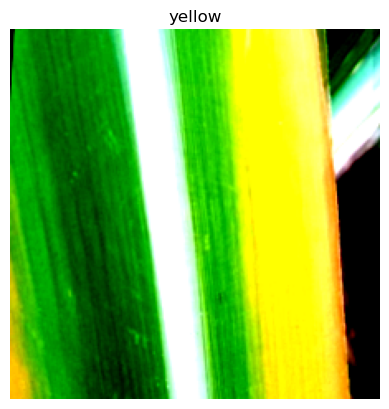

In [14]:
visualization.cek_gambar_dl(image_batch = image_batch, label_batch = label_batch, class_names = class_names)

# ResNet50 Transformer Step-by-Step

In [15]:
model = torchvision.models.resnet50(weights = weights).to(device)

In [16]:
from torchinfo import summary

In [17]:
summary(model = model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [18]:
for param in model.parameters():
    param.requires_grad = False

In [19]:
from scripts import helper

In [20]:
helper.set_seeds()

output_shape = len(class_names)

model.fc = torch.nn.Linear(in_features = 2048, 
                    out_features = output_shape, # same number of output units as our number of classes
                    bias=True).to(device)

In [21]:
summary(model = model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 5]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [22]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [23]:
from scripts import engine
# Set the random seeds
helper.set_seeds()

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader = train_data_loader,
                       test_dataloader = test_data_loader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 20,
                       device = device)

# End the timer and print out how long it took
end_time = timer()
print(f'Total waktu train: {end_time-start_time:.3f} detik')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2585 | train_acc: 0.5479 | test_loss: 1.1403 | test_acc: 0.6152
Epoch: 2 | train_loss: 0.8889 | train_acc: 0.7176 | test_loss: 0.9538 | test_acc: 0.6633
Epoch: 3 | train_loss: 0.7818 | train_acc: 0.7486 | test_loss: 0.8172 | test_acc: 0.7160
Epoch: 4 | train_loss: 0.7347 | train_acc: 0.7627 | test_loss: 0.7890 | test_acc: 0.7121
Epoch: 5 | train_loss: 0.6632 | train_acc: 0.7853 | test_loss: 0.7505 | test_acc: 0.7355
Epoch: 6 | train_loss: 0.6079 | train_acc: 0.7970 | test_loss: 0.7081 | test_acc: 0.7512
Epoch: 7 | train_loss: 0.5845 | train_acc: 0.8257 | test_loss: 0.7220 | test_acc: 0.7219
Epoch: 8 | train_loss: 0.5395 | train_acc: 0.8282 | test_loss: 0.6477 | test_acc: 0.7566
Epoch: 9 | train_loss: 0.5350 | train_acc: 0.8235 | test_loss: 0.6533 | test_acc: 0.7594
Epoch: 10 | train_loss: 0.5363 | train_acc: 0.8187 | test_loss: 0.6153 | test_acc: 0.7840
Epoch: 11 | train_loss: 0.4971 | train_acc: 0.8441 | test_loss: 0.5796 | test_acc: 0.7754
Epoch: 12 | train_l

In [24]:
PATH = Path('models')
MODEL_NAME = 'ResNet50_AutoTransform_AugMix_TrivialAW.pth'

SAVE_PATH = PATH/MODEL_NAME

In [25]:
print(f'Saving model to: {SAVE_PATH}')
torch.save(obj = model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f = SAVE_PATH)

Saving model to: models\ResNet50_AutoTransform_AugMix_TrivialAW.pth


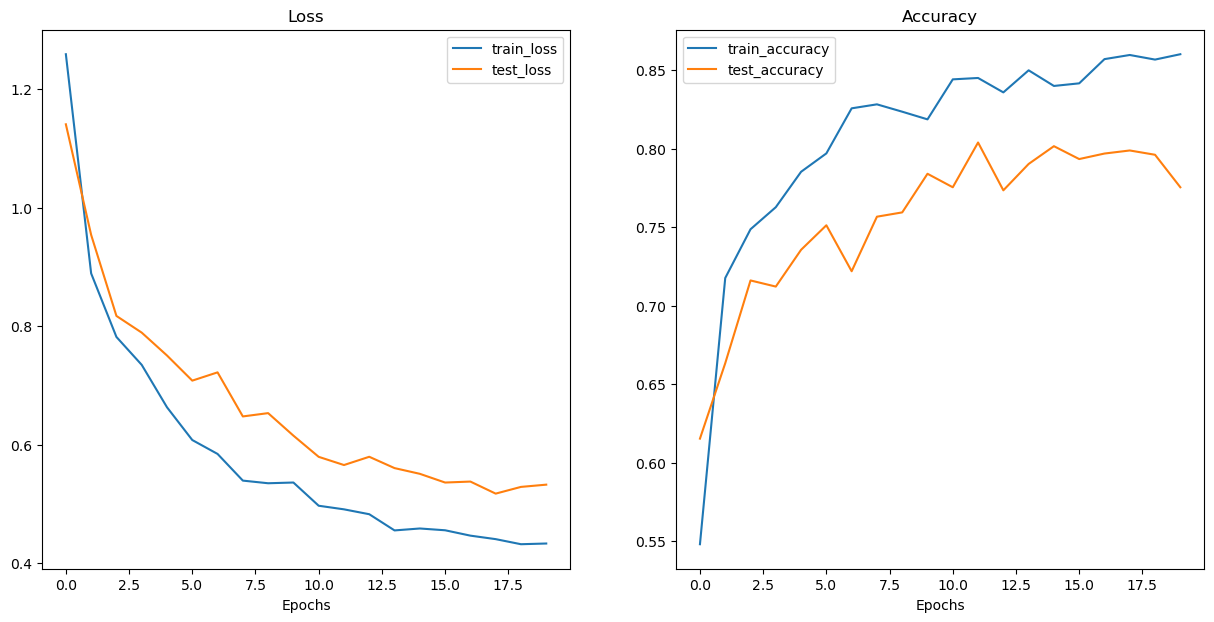

In [26]:
from scripts import prediksi
prediksi.plot_grafik_loss(results)

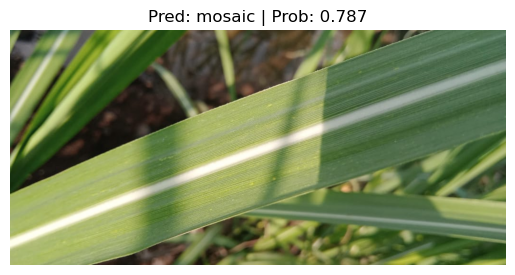

In [27]:
custom_img_path = Path('datasets/test/healthy/healthy (11).jpeg')

prediksi.pred_gambar(model = model,
                image_path = custom_img_path,
                class_names=class_names,
                transform = test_transform,
                device = device)

  0%|          | 0/16 [00:00<?, ?it/s]

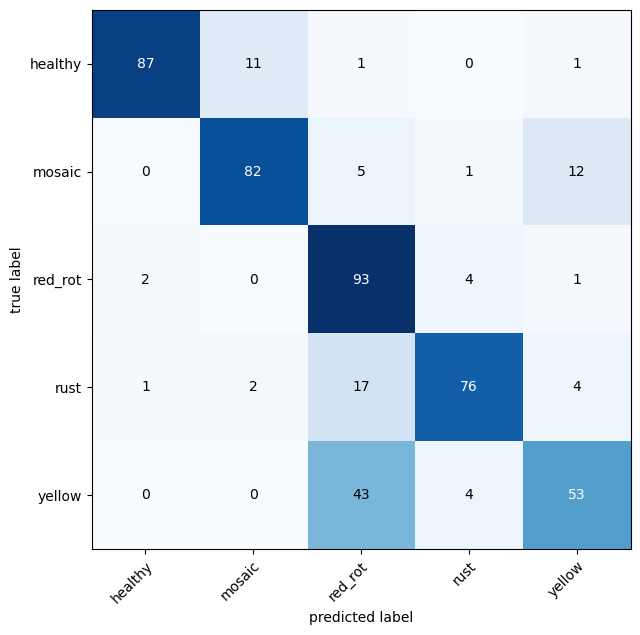

In [28]:
prediksi.confusion_matrix(
    model = model,
    test_dataloader = test_data_loader,
    device = device,
    class_names = class_names
)